## 📦 Ecommerce Analysis

In [1]:
import pandas as pd
import os

In [14]:
class EcommerceAnalyzer:
    def __init__(self, data_dir):
        """Initialize the analyzer with the data directory."""
        self.data_dir = data_dir
        self.data = {}
        
    def load_data(self):
        """Load all CSV files from the data directory."""
        print("Loading data...")
        for file in os.listdir(self.data_dir):
            if file.endswith('.csv'):
                name = file[:-4]  # Remove .csv extension
                print(f"Loading {name}...")
                self.data[name] = pd.read_csv(f"{self.data_dir}/{file}")
        print("Data loading complete!")
        
    def get_dataset_summary(self):
        """Print basic info about each dataset."""
        for name, df in self.data.items():
            print(f"\n=== {name.upper()} ===")
            print(f"Shape: {df.shape}")
            print(df.head())
            print(df.dtypes)
            print(df.isnull().sum())

In [ ]:
def main():
    # Initialize the analyzer
    data_dir = r"c:\Users\sky1m\OneDrive\Desktop\Binay\cap\Ecommerce - Copy"
    analyzer = EcommerceAnalyzer(data_dir)
    
    # Load the data
    analyzer.load_data()
    
    # Print basic info about each dataset
    analyzer.get_dataset_summary()

if __name__ == "__main__":
    main()

## 📈 Sales & Customer Forecasting

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [18]:
class EcommerceForecaster:
    def __init__(self, data_dir):
        """Initialize with data directory."""
        self.data_dir = data_dir
        self.orders_df = None
        self.payments_df = None
        
    def load_data(self):
        """Load required data files."""
        print("Loading data...")
        self.orders_df = pd.read_csv(f"{self.data_dir}/orders.csv", 
                                   parse_dates=['order_purchase_timestamp'])
        self.payments_df = pd.read_csv(f"{self.data_dir}/payments.csv")
        print("Data loaded successfully!")
    
    def prepare_sales_data(self):
        """Prepare daily sales data."""
        # Merge orders with payments
        df = pd.merge(
            self.orders_df[['order_id', 'order_purchase_timestamp']],
            self.payments_df[['order_id', 'payment_value']],
            on='order_id',
            how='left'
        )
        
        # Process dates and aggregate
        df['date'] = pd.to_datetime(df['order_purchase_timestamp']).dt.normalize()
        daily_sales = df.groupby('date')['payment_value'].sum().reset_index()
        daily_sales.columns = ['ds', 'y']
        
        # Ensure we have a row for every date in the range
        date_range = pd.date_range(
            start=daily_sales['ds'].min(),
            end=daily_sales['ds'].max(),
            freq='D'
        )
        daily_sales = daily_sales.set_index('ds').reindex(date_range).fillna(0).reset_index()
        daily_sales.columns = ['ds', 'y']
        
        return daily_sales
    
    
    def plot_sales_trend(self, df):
        """Plot sales trend over time."""
        # Ensure date is in datetime format for plotting
        df['date'] = pd.to_datetime(df['ds'])
        
        # Plot daily sales
        plt.figure(figsize=(12, 6))
        plt.plot(df['date'], df['y'])
        plt.title('Daily Sales Over Time')
        plt.xlabel('Date')
        plt.ylabel('Sales Amount')
        plt.grid(True)
        plt.show()
        
        # Group by month for monthly view (without resampling)
        df['month'] = df['date'].dt.to_period('M')
        monthly = df.groupby('month')['y'].sum().reset_index()
        monthly['month'] = monthly['month'].dt.to_timestamp()
        
        # Plot monthly sales
        plt.figure(figsize=(12, 6))
        plt.bar(monthly['month'], monthly['y'])
        plt.title('Monthly Sales')
        plt.xlabel('Month')
        plt.ylabel('Total Sales')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    
    
    def save_forecast(self, df, filename='sales_forecast.csv'):
        """Save forecast results to CSV."""
        df.to_csv(filename, index=False)
        print(f"Forecast saved to {filename}")

Loading data...
Loading data...
Data loaded successfully!
Preparing sales data...
Generating sales trends...


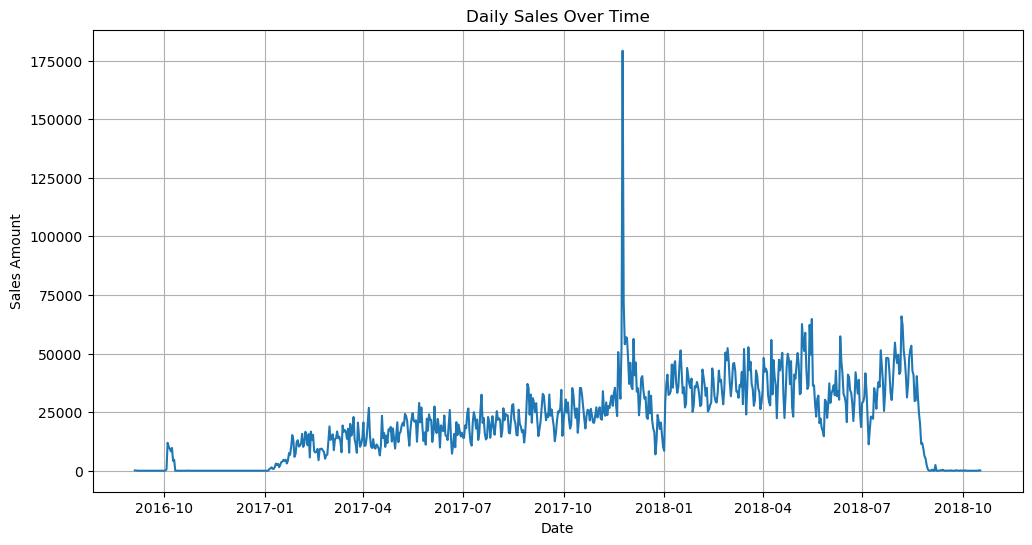

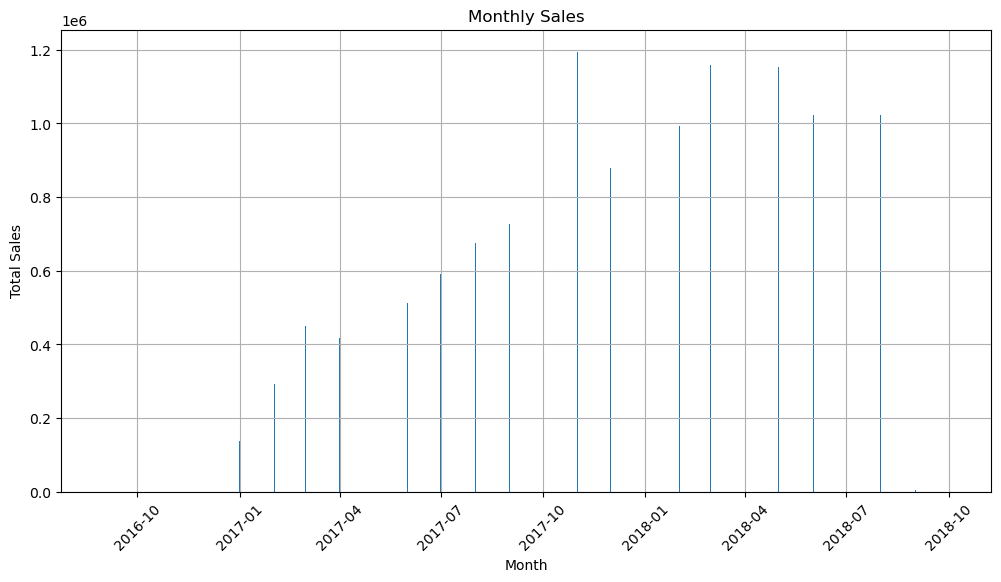

Forecast saved to sales_forecast.csv

=== SALES SUMMARY ===
Total days analyzed: 774
Total sales: $16,008,872.12
Average daily sales: $20,683.30

Daily sales data saved to 'daily_sales.csv'


In [19]:
def main():
    # Initialize the analyzer
    data_dir = r"c:\Users\sky1m\OneDrive\Desktop\Binay\cap\Ecommerce - Copy"
    analyzer = EcommerceForecaster(data_dir)
    
    # Load and prepare data
    print("Loading data...")
    analyzer.load_data()
    
    # Prepare sales data
    print("Preparing sales data...")
    sales_data = analyzer.prepare_sales_data()
    
    # Plot sales trends
    print("Generating sales trends...")
    analyzer.plot_sales_trend(sales_data)
    
    # Save the data and print summary
    analyzer.save_forecast(sales_data)
    
    # Print summary
    print("\n=== SALES SUMMARY ===")
    print(f"Total days analyzed: {len(sales_data)}")
    print(f"Total sales: ${sales_data['y'].sum():,.2f}")
    print(f"Average daily sales: ${sales_data['y'].mean():,.2f}")
    
    # Save the raw data for reference
    sales_data.to_csv('daily_sales.csv', index=False)
    print("\nDaily sales data saved to 'daily_sales.csv'")

if __name__ == "__main__":
    main()

## 🧩 Customer Segmentation & ⚠️ Return Prediction

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

class RFMAnalyzer:
    def __init__(self, data_dir):
        """Initialize the RFM analyzer with the data directory."""
        self.data_dir = data_dir
        self.orders_df = None
        self.customers_df = None
        self.payments_df = None
        
    def load_data(self):
        """Load the required data files."""
        print("Loading data...")
        self.orders_df = pd.read_csv(f"{self.data_dir}/orders.csv", 
                                   parse_dates=['order_purchase_timestamp'])
        self.customers_df = pd.read_csv(f"{self.data_dir}/customers.csv")
        self.payments_df = pd.read_csv(f"{self.data_dir}/payments.csv")
        
    def calculate_rfm(self):
        """Calculate basic RFM metrics for each customer."""
        # Calculate total payment per order
        order_totals = self.payments_df.groupby('order_id')['payment_value'].sum().reset_index()
        
        # Merge orders with payments
        orders_with_payments = self.orders_df.merge(order_totals, on='order_id', how='inner')
        
        # Calculate RFM metrics
        analysis_date = orders_with_payments['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
        
        rfm = orders_with_payments.groupby('customer_id').agg({
            'order_purchase_timestamp': lambda x: (analysis_date - x.max()).days,
            'order_id': 'count',
            'payment_value': 'sum'
        }).reset_index()
        
        rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
        
        # Handle any potential zeros in monetary (though unlikely)
        rfm = rfm[rfm['monetary'] > 0]
        
        return rfm

In [23]:
def main():
    # Initialize the analyzer
    data_dir = r"c:\Users\sky1m\OneDrive\Desktop\Binay\cap\Ecommerce - Copy"
    analyzer = RFMAnalyzer(data_dir)
    
    # Load and process data
    analyzer.load_data()
    rfm = analyzer.calculate_rfm()
    
    # Print basic RFM statistics
    print("\nRFM Analysis Results:")
    print("-" * 50)
    print(f"Total customers analyzed: {len(rfm)}")
    print("\nAverage metrics per customer:")
    print(rfm[['recency', 'frequency', 'monetary']].mean())
    
    # Save results to CSV
    output_file = "rfm_results.csv"
    rfm.to_csv(output_file, index=False)
    print(f"\nRFM analysis saved to {output_file}")

if __name__ == "__main__":
    main()

Loading data...

RFM Analysis Results:
--------------------------------------------------
Total customers analyzed: 99437

Average metrics per customer:
recency      290.902752
frequency      1.000000
monetary     160.995124
dtype: float64

RFM analysis saved to rfm_results.csv


## Few Other Visualizations 

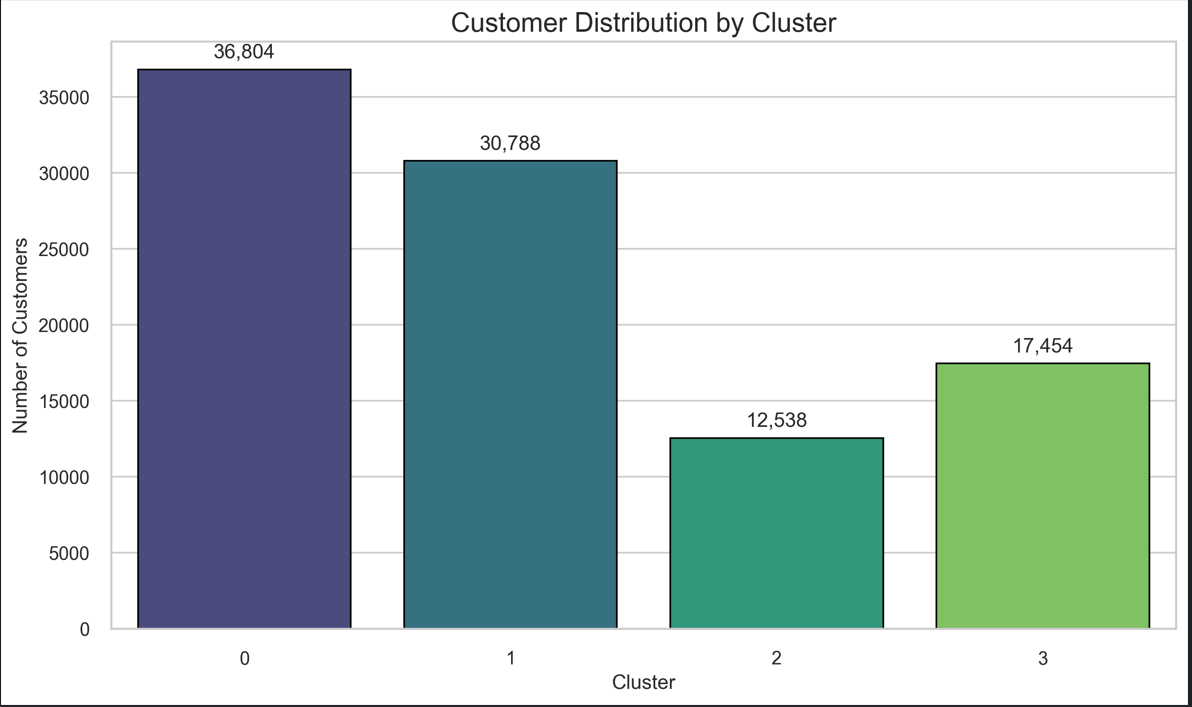


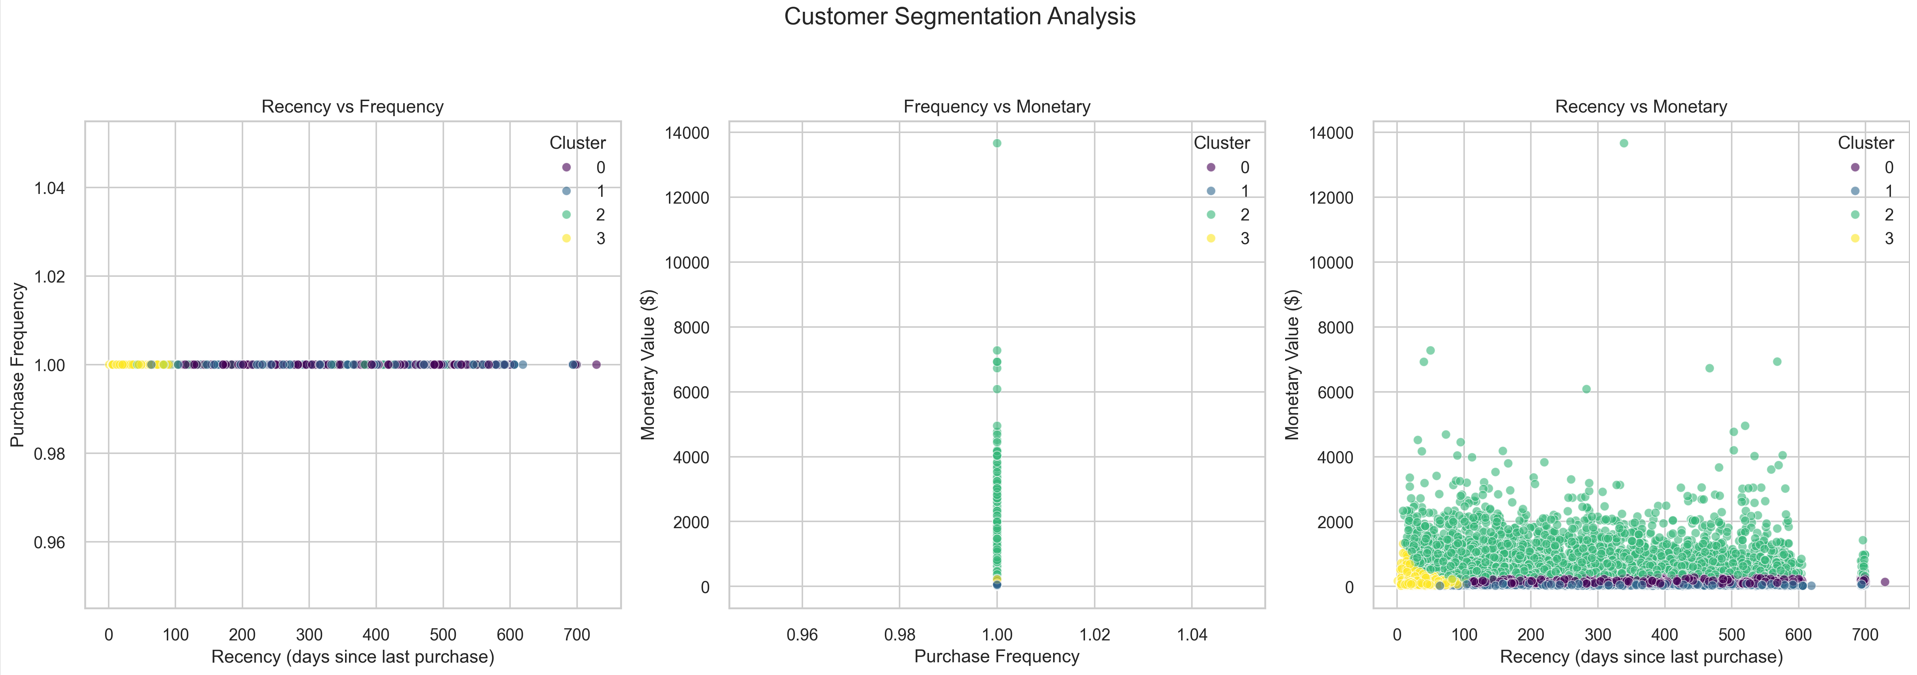

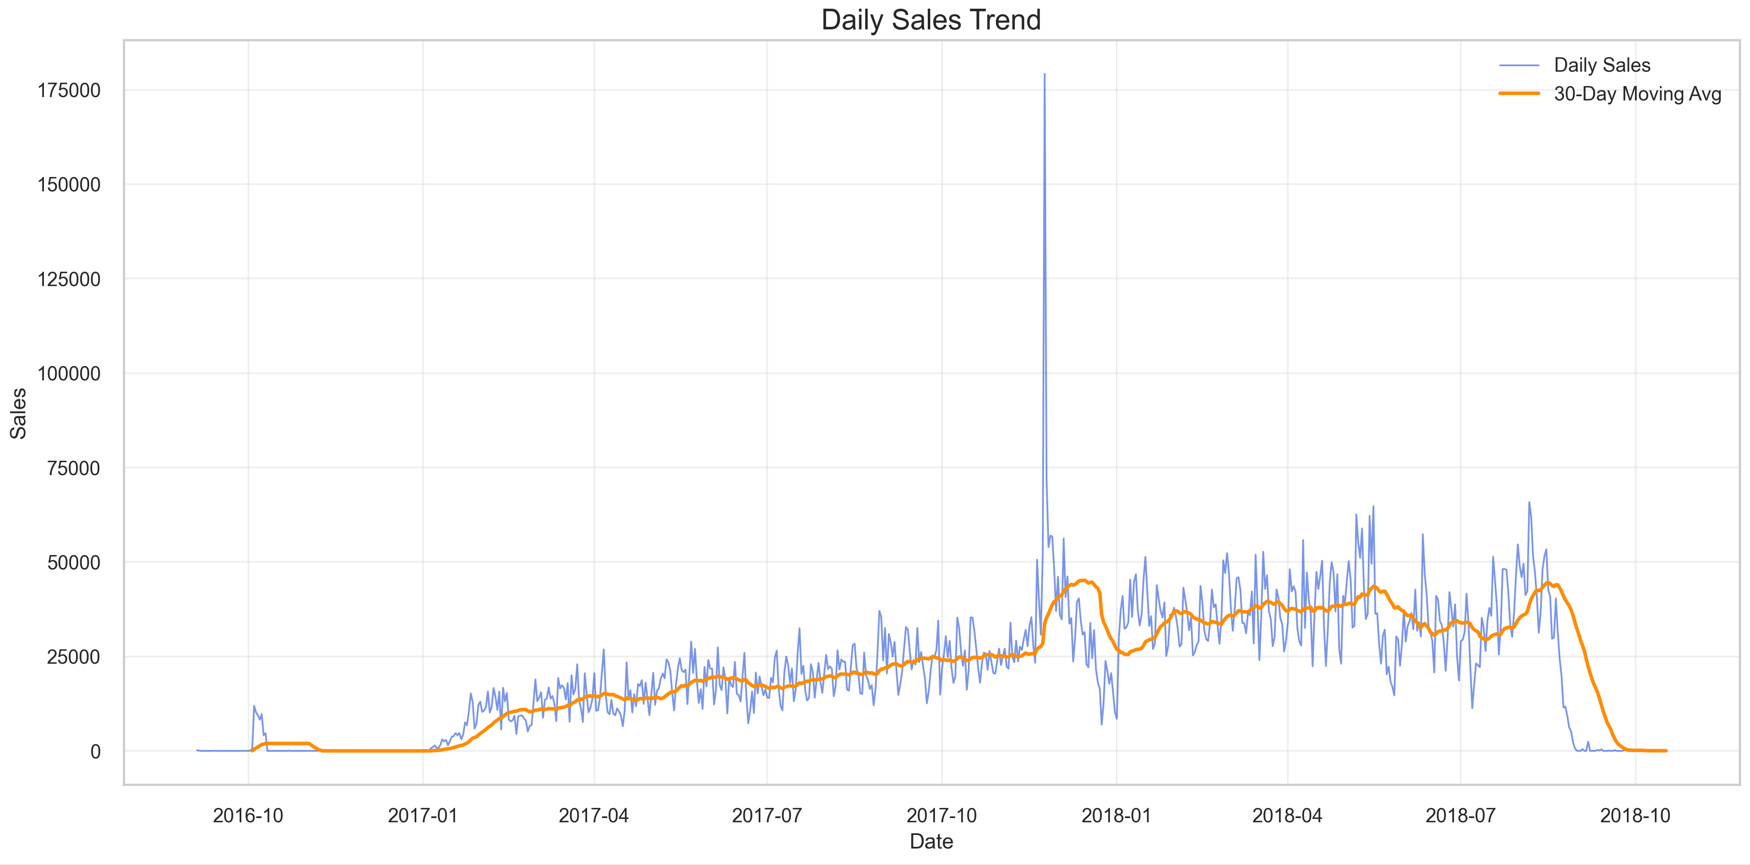

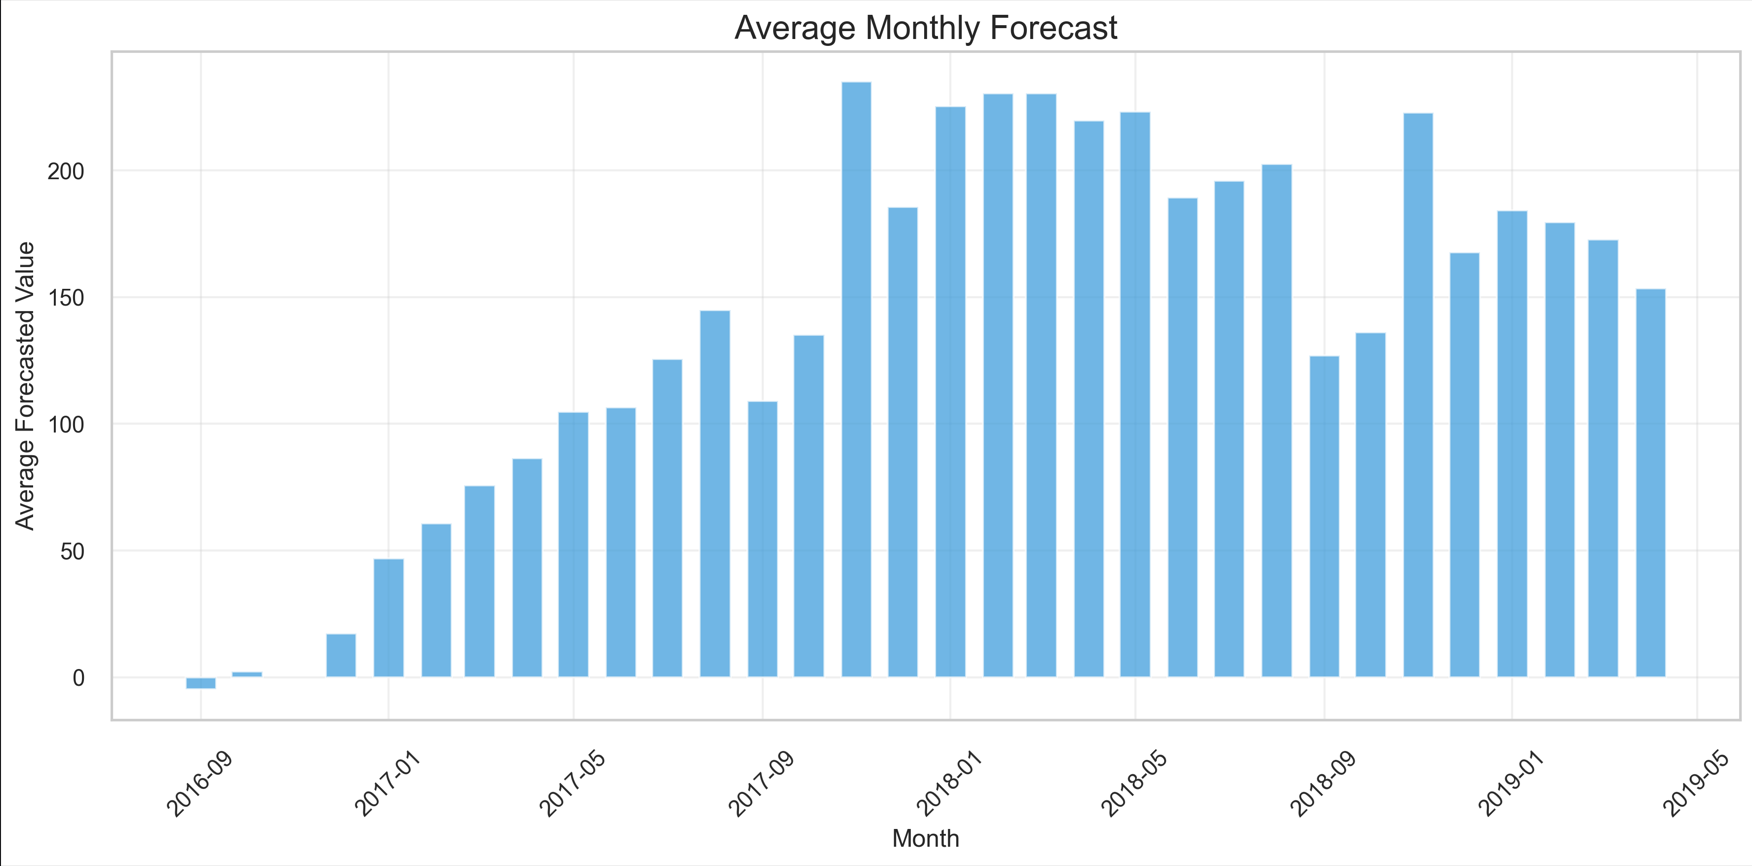

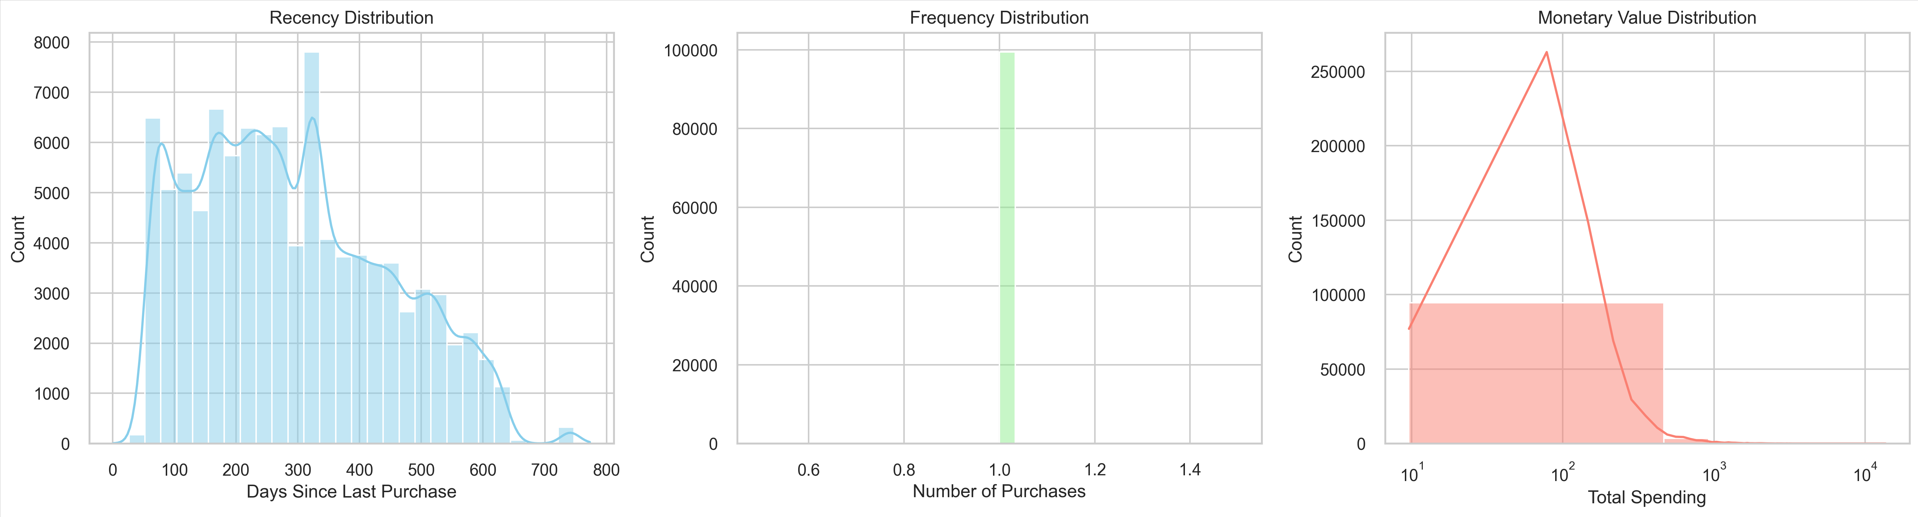

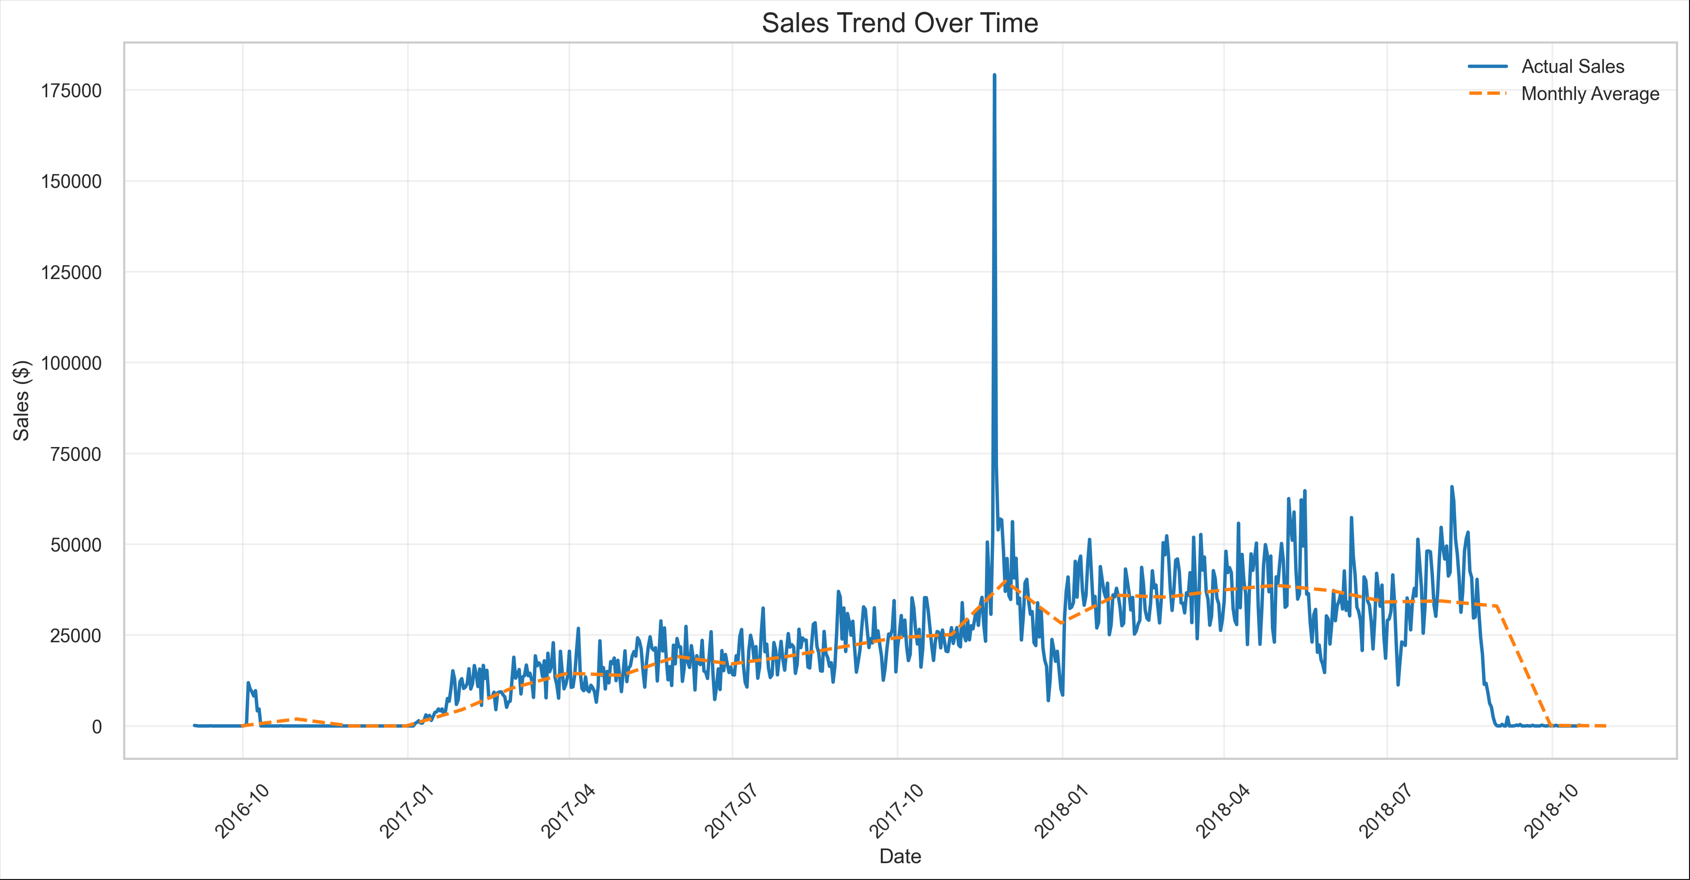

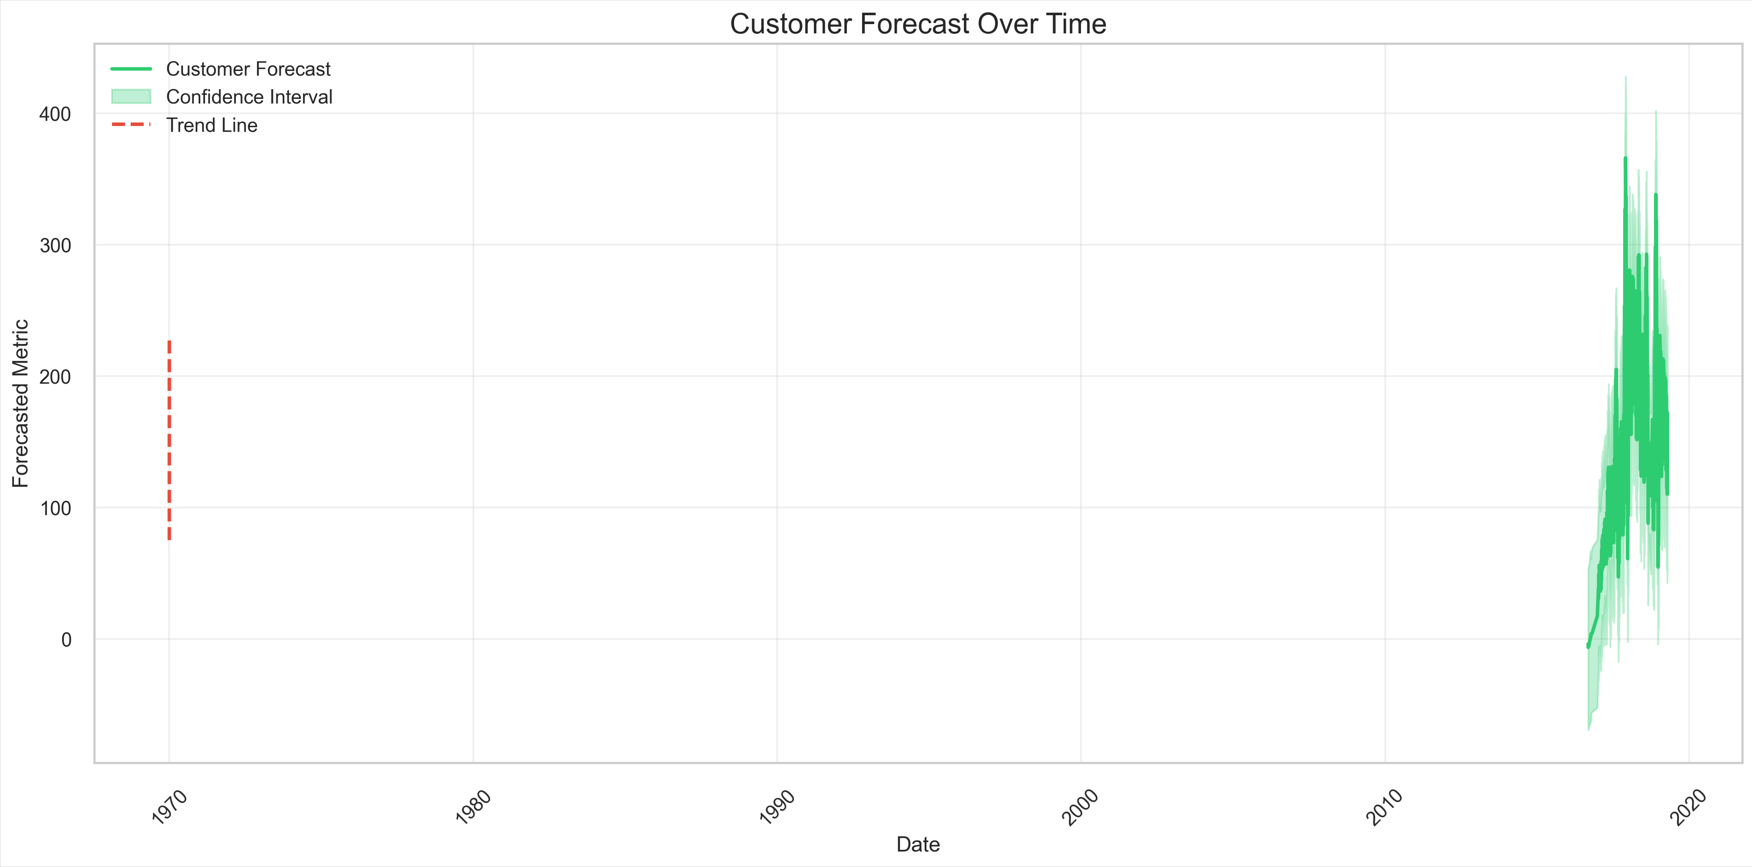